# 感度分析

感度分析（sensitivity analysis）はモデルにさまざまなデータを入力し、推定した因果効果についての妥当性を評価する方法。

入力を変化させたときの出力の変化の「方向（正負）」と「度合い（強さ）」を測る。



## E-value

E-Valueは未観測の交絡因子の影響の強さを簡単に測る方法。

$$
\text { E-Value }= \text{RR} +\sqrt{ \text{RR} \times( \text{RR} -1)}
$$

$\text{RR}$は相対リスク（relative risk）で、例えば「キャンペーンの有無」が「商品の購入の有無」に与える効果を調べたい場合だと

$$
\text{RR} =
\frac{ 処置群での購入の割合 }{ 対照群での購入の割合 }
$$

となる。これはRRが1より大きい場合で、もしRRが1より小さくなるなら逆数を用いる。

E-valueが大きいほど、観測された結果と処置の関係は因果関係に近い（ロバストである）と解釈される。

例えばRRが1.5（処置で1.5倍改善）だとE-valueは2.37になる。これは、もし未観測の交絡因子でこの推定結果を説明するには、未観測の交絡因子が結果変数と処置変数の両方と2.37倍の相対リスクで関連している必要があることを示す。


In [7]:
# 例
p_treatment = 0.15 # 処置群での購入割合
p_control = 0.10 # 対照群での購入割合

RR = p_treatment / p_control

import math
E = RR + math.sqrt(RR * (RR - 1))
print(f"E-value: {E:.3g}")

E-value: 2.37


:::{card} 参考文献

- [VanderWeele, T. J., & Ding, P. (2017). Sensitivity analysis in observational research: introducing the E-value. Annals of internal medicine, 167(4), 268-274.](https://www.acpjournals.org/doi/pdf/10.7326/m16-2607?casa_token=eV2YvvqK_ZgAAAAA:VR_9M5eLezZrikd03IZXew8fJjBcPIW3E7QT_ZYrHh6M-shVOxEwmZVWDWGFFWuNH3B9w7inywr6)
- [VanderWeele, T. J., Ding, P., & Mathur, M. (2019). Technical considerations in the use of the E-value. Journal of Causal Inference, 7(2), 20180007.](https://www.degruyter.com/document/doi/10.1515/jci-2018-0007/html)

:::

## 部分決定係数

Imbens (2003)が提案した、未観測の交絡因子の強さを把握する手法。

共変量$X$、結果$Y$、処置$T$、未観測の交絡因子$U$を用いたパラメトリックモデルを考える。

$U$は確率0.5のベルヌーイ分布に従うとする。

$$
U_i \stackrel{\text { ind }}{\sim} \operatorname{Bern}(1 / 2)
$$

$T$はロジスティック回帰モデルを仮定する。

$$
T_i \mid X_i, U_i \stackrel{\text { ind }}{\sim} \operatorname{Bern}\left(\operatorname{sigmoid}\left(\gamma X_i+\alpha U_i\right)\right)
$$

$Y$は線形回帰モデルを仮定する。

$$
Y_i \mid X_i, T_i, U_i \stackrel{\text { ind }}{\sim} \operatorname{Norm}\left(\tau T_i+\beta X_i+\delta U_i, \sigma^2\right)
$$

$U$は観測できていないが、$U$の係数$a, \delta$を使って$U$の影響を判断できる



$Y$の部分決定係数$R^2_{Y, par}(\alpha, \delta)$は

$$
R^2_{Y, par}(\alpha, \delta)
= 1 - \frac{RSS_{full}}{RSS_{reduced}}
$$

ここで$RSS_{full}$は$U$を含むという意味でfullのモデルの残差平方和。$RSS_{reduced}$は観測した変数のみのモデルの残差平方和。

未観測の交絡因子$U$の影響が少ない場合、$RSS_{full} \approx RSS_{reduced}$になり$R^2_{Y, par}(\alpha, \delta)$は0に近づく。

### 実装

PySensemakrパッケージが便利。

In [2]:
!pip install PySensemakr


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import sensemakr as smkr
import statsmodels.formula.api as smf

# loads data
darfur = smkr.load_darfur()
# runs regression model
reg_model = smf.ols(formula='peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + '\
                    'pastvoted + hhsize_darfur + female + village', data=darfur)
darfur_model = reg_model.fit()

# Create a sensemakr object and print summary of results
darfur_sense = smkr.Sensemakr(model = darfur_model,
                              treatment = "directlyharmed",
                              benchmark_covariates = ["female"],
                              kd = [1,2,3])
darfur_sense.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1 : 0.139
  Robustness Value, q = 1 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187 % of the residual variance of the treatment to fully account for the observed estimated effect.

-- Robustness Valu

/usr/local/lib/python3.10/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float
/usr/local/lib/python3.10/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float



> Sensitivity Statistics

の箇所に部分決定係数が表示されている

```
Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1 : 0.139
  Robustness Value, q = 1 alpha = 0.05 : 0.076 
```


- `Partial R2 of treatment with outcome`：部分決定係数
- `Robustness Value, q = 1`： **Robustness Value** は未観測の交絡因子が処置変数と結果変数に与える影響を定量的に測る指標。値が大きいほど影響を受けないことを示す。
    - 例えばRobustness Valueが0.1なら、処置変数と結果変数の両方の残差の分散のうち10%を説明するほどの未観測の交絡因子が存在しない限り、処置の結果への影響はロバストであるという意味。
- `Robustness Value, q = 1 alpha = 0.05`：統計的有意性も加味したもの。

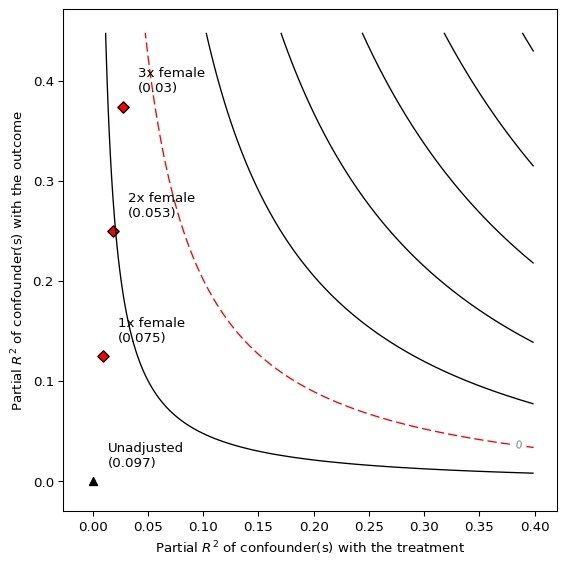

In [4]:
# contour plot for the estimate
darfur_sense.plot()

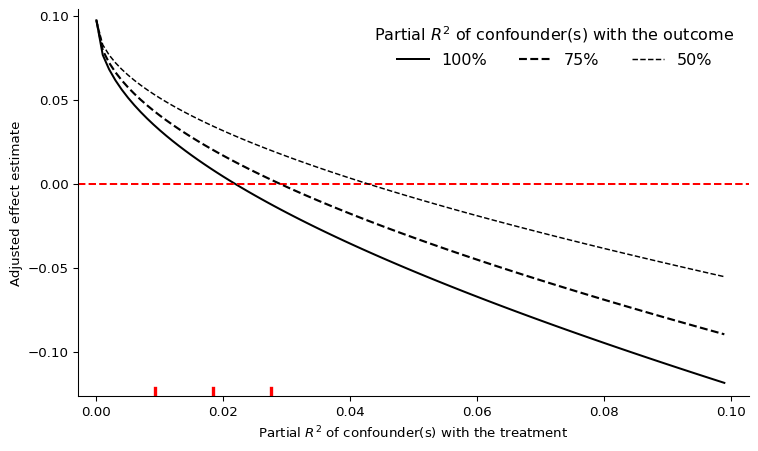

In [5]:
# extreme scenarios plot
darfur_sense.plot(plot_type = 'extreme')

:::{card} 参考文献

- [Imbens, G. W. (2003). Sensitivity to exogeneity assumptions in program evaluation. American Economic Review, 93(2), 126-132.](https://scholar.harvard.edu/imbens/files/sensitivity_to_exogeneity_assumptions_in_program_evaluation.pdf)

:::

## 機械学習を利用した感度分析1：Veitch & Zaveri (2020)

[Veitch & Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html)は機械学習を用いた感度分析を提案した

長所は

1. 未観測の交絡因子が1つでも複数でも対応可能
2. 非線形モデルにも対応可能

短所は
1. 大体の傾向しか出せない
2. サンプル数が小さいと精度が低い


実装

- [anishazaveri/austen_plots](https://github.com/anishazaveri/austen_plots)



:::{card} 参考文献

- [Veitch, V., & Zaveri, A. (2020). Sense and sensitivity analysis: Simple post-hoc analysis of bias due to unobserved confounding. Advances in neural information processing systems, 33, 10999-11009.](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html)
- [<論文要約> Sense and Sensitivity Analysis: Simple Post-Hoc Analysis of Bias Due to Unobserved Confounding (NeurIPS2020) - 名前はまだない](https://saltcooky.hatenablog.com/entry/2021/08/06/021526)

:::

## 機械学習を利用した感度分析2：Chernozhukov, et al. (2022)

[Chernozhukov, et al. (2022)](https://www.nber.org/papers/w30302)は部分線形モデル（DML）の感度分析を提案

[DoWhy documentation](https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/sensitivity_analysis_nonparametric_estimators.html) が概要の解説と実装の両面で参考になる


:::{card} 参考文献

- [Chernozhukov, V., Cinelli, C., Newey, W., Sharma, A., & Syrgkanis, V. (2022). Long story short: Omitted variable bias in causal machine learning (No. w30302). National Bureau of Economic Research.](https://www.nber.org/papers/w30302)
- [Sensitivity analysis for non-parametric causal estimators — DoWhy documentation](https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/sensitivity_analysis_nonparametric_estimators.html)

:::

## Semiparametric

[Semiparametric sensitivity analysis: unmeasured confounding in observational studies | Biometrics | Oxford Academic](https://academic.oup.com/biometrics/article/80/4/ujae106/7821107)


## 企業での利用例

### Uber

Uberの因果推論フレームワークCeViChEにおいて感度分析を行っている

主に

- プラセボテスト
- 関係のない交絡因子の追加・置換
- サブセットデータを用いた検証
- 選択バイアスの検証

を行って多角的に感度分析している



:::{card} 参考文献

[(Share) KDD2021 Case Study #1 Causal Impact Analysis - CeViChE - Google スライド](https://docs.google.com/presentation/d/1FvRtis2fm4c2R7XmRKWMTtZaZjUObW1fGxpNmapmjKI/edit#slide=id.ge6ef5be800_0_478)

:::

### Spotify

[Zeitler, J., Vlontzos, A., & Gilligan-Lee, C. M. (2023, August). Non-parametric identifiability and sensitivity analysis of synthetic control models. In Conference on Causal Learning and Reasoning (pp. 850-865). PMLR.](https://proceedings.mlr.press/v213/zeitler23a.html)

タイトルの通り、Synthetic Controlの感度分析

著者のうちのVlontzosはSpotifyの人

